In [23]:
import numpy as np
from scipy.special import iv, kv

# Constants
G = 4.302e-6  # Gravitational constant in M_sun^-1 (km/s)^2 kpc
R_0 = 8.0  # Scale length for disk (kpc)

# Functions for rotation curves

# 1. Dark Matter Rotation Curve (v_DM)
def v_DM(r, rho_DM_0, r_s):
    if r_s <= 0 or np.any(r <= 0):
        return np.zeros_like(r)
    M_DM = 4 * np.pi * rho_DM_0 * R_0 * (R_0 + r_s)**2 * (np.log((r + r_s) / r_s) - r / (r + r_s))
    return np.sqrt(np.maximum(0, G * M_DM / r))

# 2. Bulge Rotation Curve (v_bulge)
def v_bulge(r, rho_b0, r_b):
    if r_b <= 0 or np.any(r <= 0):
        return np.zeros_like(r)
    M_b = 4 * np.pi * rho_b0 * r_b**3 * (np.arcsinh(r / r_b) - (r / r_b) / np.sqrt(1 + (r / r_b)**2))
    return np.sqrt(np.maximum(0, G * M_b / r))

# 3. Disk Rotation Curve (v_disk)
def v_disk(r, Sigma_0, R_d):
    if R_d <= 0 or np.any(r <= 0):
        return np.zeros_like(r)
    Sigma_0_kpc2 = Sigma_0 * 1e6  # Convert surface density to kpc^2
    v2_disk = (
        4 * np.pi * G * Sigma_0_kpc2 * R_d * (r / (2 * R_d))**2 * np.exp(R_0 / R_d) *
        (
            iv(0, r / (2 * R_d)) * kv(0, r / (2 * R_d)) -
            iv(1, r / (2 * R_d)) * kv(1, r / (2 * R_d))
        )
    )
    return np.sqrt(np.maximum(0, v2_disk))

def v_total(r,rho_DM_0,r_s,rho_b0,r_b,Sigma_0, R_d):
    return np.sqrt(v_DM(r,rho_DM_0,r_s)**2 + v_bulge(r,rho_b0,r_b)**2 + v_disk(r,Sigma_0, R_d)**2)

# Load your rotation curve data
data_file = "bhatt_all.txt"  # Replace with your file name
data = np.loadtxt(data_file)  # Adjust if your file has headers or different delimiters

mw_r = data[0:51:, 2]  # Radius
v_data = data[0:51:, 3]  # Observed velocity
v_err = data[0:51:, 4] 


# Data (replace with your actual data)
r_data = mw_r  # Radial positions (kpc)
v_data = v_data  # Observed rotation velocities (km/s)
err_data = v_err  # Errors in observed velocities

# Parameters
param_names = ['rho_DM_0', 'r_s', 'rho_b0', 'r_b', 'Sigma_0', 'R_d']
ranges = [[1e6, 3e6], [10, 250], [0.5e13, 2e13], [0.001, 0.1], [50, 500], [1, 20]]


import numpy as np
from ultranest import ReactiveNestedSampler
import matplotlib.pyplot as plt
import corner

# Updated priors
def flat_prior(cube):
    params = cube.copy()
    for i, fid in enumerate(ranges):
        params[i] = cube[i] * (fid[1] - fid[0]) + fid[0]
    return params

def gaussian_prior(cube):
    params = cube.copy()
    for i, fid in enumerate(ranges):
        if i == 4:  # Sigma_0 (Gaussian: mean=48, std=8)
            params[i] = 48 + 8 * np.random.randn()
        elif i == 5:  # R_d (Gaussian: mean=2.3, std=0.6)
            params[i] = 2.3 + 0.6 * np.random.randn()
        else:
            params[i] = cube[i] * (fid[1] - fid[0]) + fid[0]
    return params
    

# Run sampling with flat prior
flat_sampler = ReactiveNestedSampler(
    param_names, llike, flat_prior,
    log_dir=ultraroot + "/flat",
    resume='overwrite'
)
flat_results = flat_sampler.run(max_ncalls=1e6)

# Run sampling with Gaussian prior
gaussian_sampler = ReactiveNestedSampler(
    param_names, llike, gaussian_prior,
    log_dir=ultraroot + "/gaussian",
    resume='overwrite'
)
gaussian_results = gaussian_sampler.run(max_ncalls=1e6)

# Combine the results for visualization
flat_samples = flat_results['samples']
gaussian_samples = gaussian_results['samples']

# Create a corner plot
fig = corner.corner(
    flat_samples, labels=param_names, color='blue', alpha=0.5, show_titles=True,
    label_kwargs={"fontsize": 12}
)
corner.corner(
    gaussian_samples, fig=fig, color='red', alpha=0.5,
    label_kwargs={"fontsize": 12}
)

plt.show()


[ultranest] Sampling 400 live points from prior ...


C:\Users\sutir\AppData\Local\Temp\ipykernel_19768\2926669123.py:31: RuntimeWarning: invalid value encountered in multiply
  iv(0, r / (2 * R_d)) * kv(0, r / (2 * R_d)) -
C:\Users\sutir\AppData\Local\Temp\ipykernel_19768\2926669123.py:32: RuntimeWarning: invalid value encountered in multiply
  iv(1, r / (2 * R_d)) * kv(1, r / (2 * R_d))


KeyboardInterrupt: 

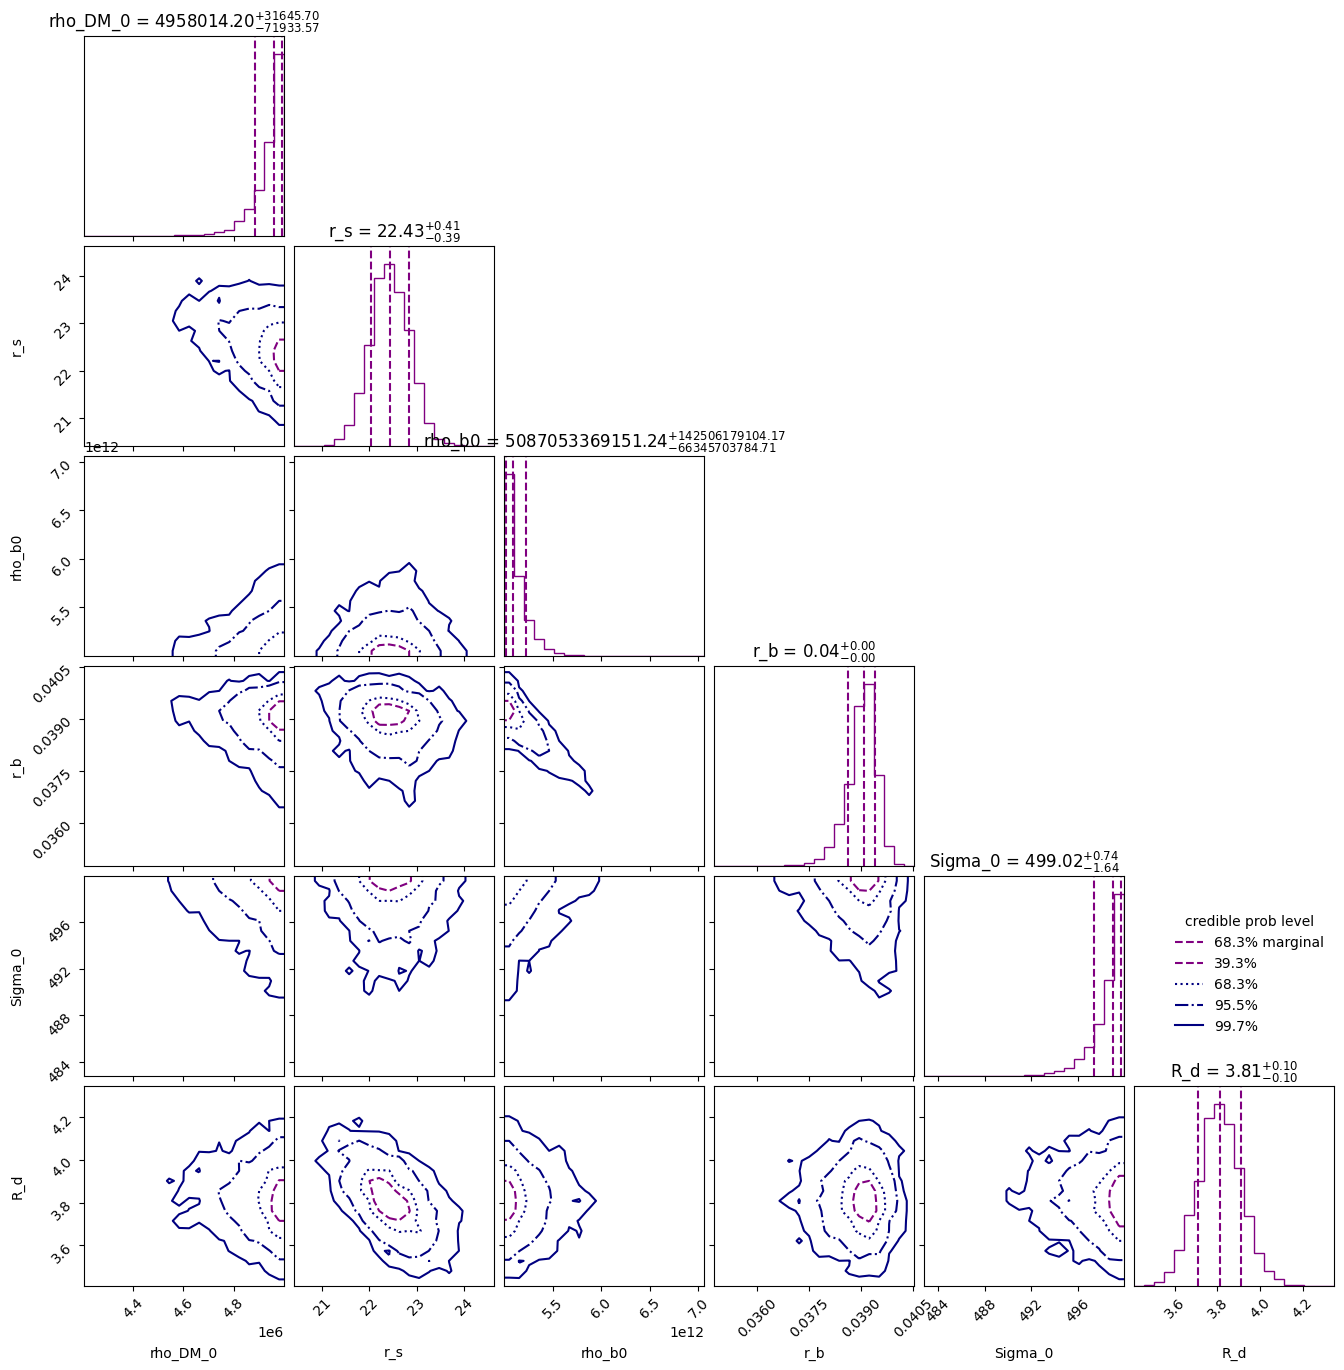

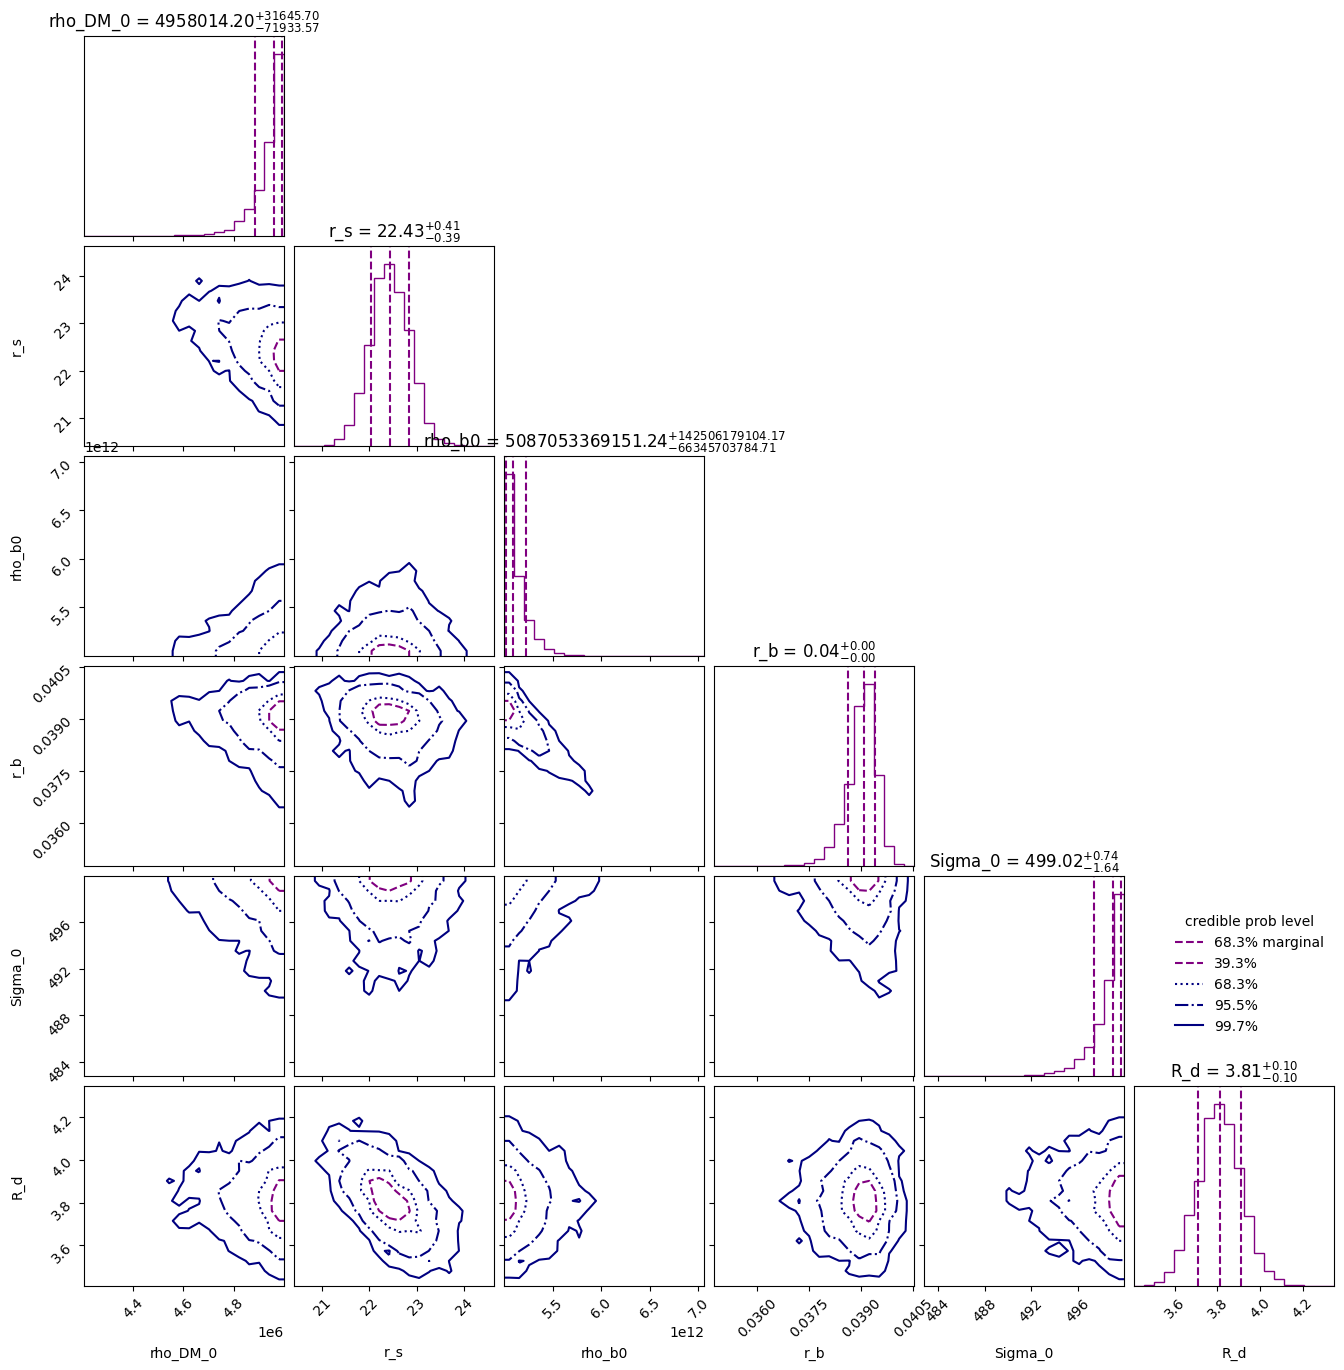

In [14]:
import numpy as np 
import scipy as sp  
import matplotlib.pyplot as plt  
import ultranest  
import ultranest.stepsampler as ultrastep  
from ultranest.plot import cornerplot
cornerplot(flat_results)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .48 [-127.7763..-127.7761]*| it/evals=9856/276823 eff=3.5655% N=400     0 0 
[ultranest] Likelihood function evaluations: 276823
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -147.7 +- 0.1442
[ultranest] Effective samples strategy satisfied (ESS = 2407.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.


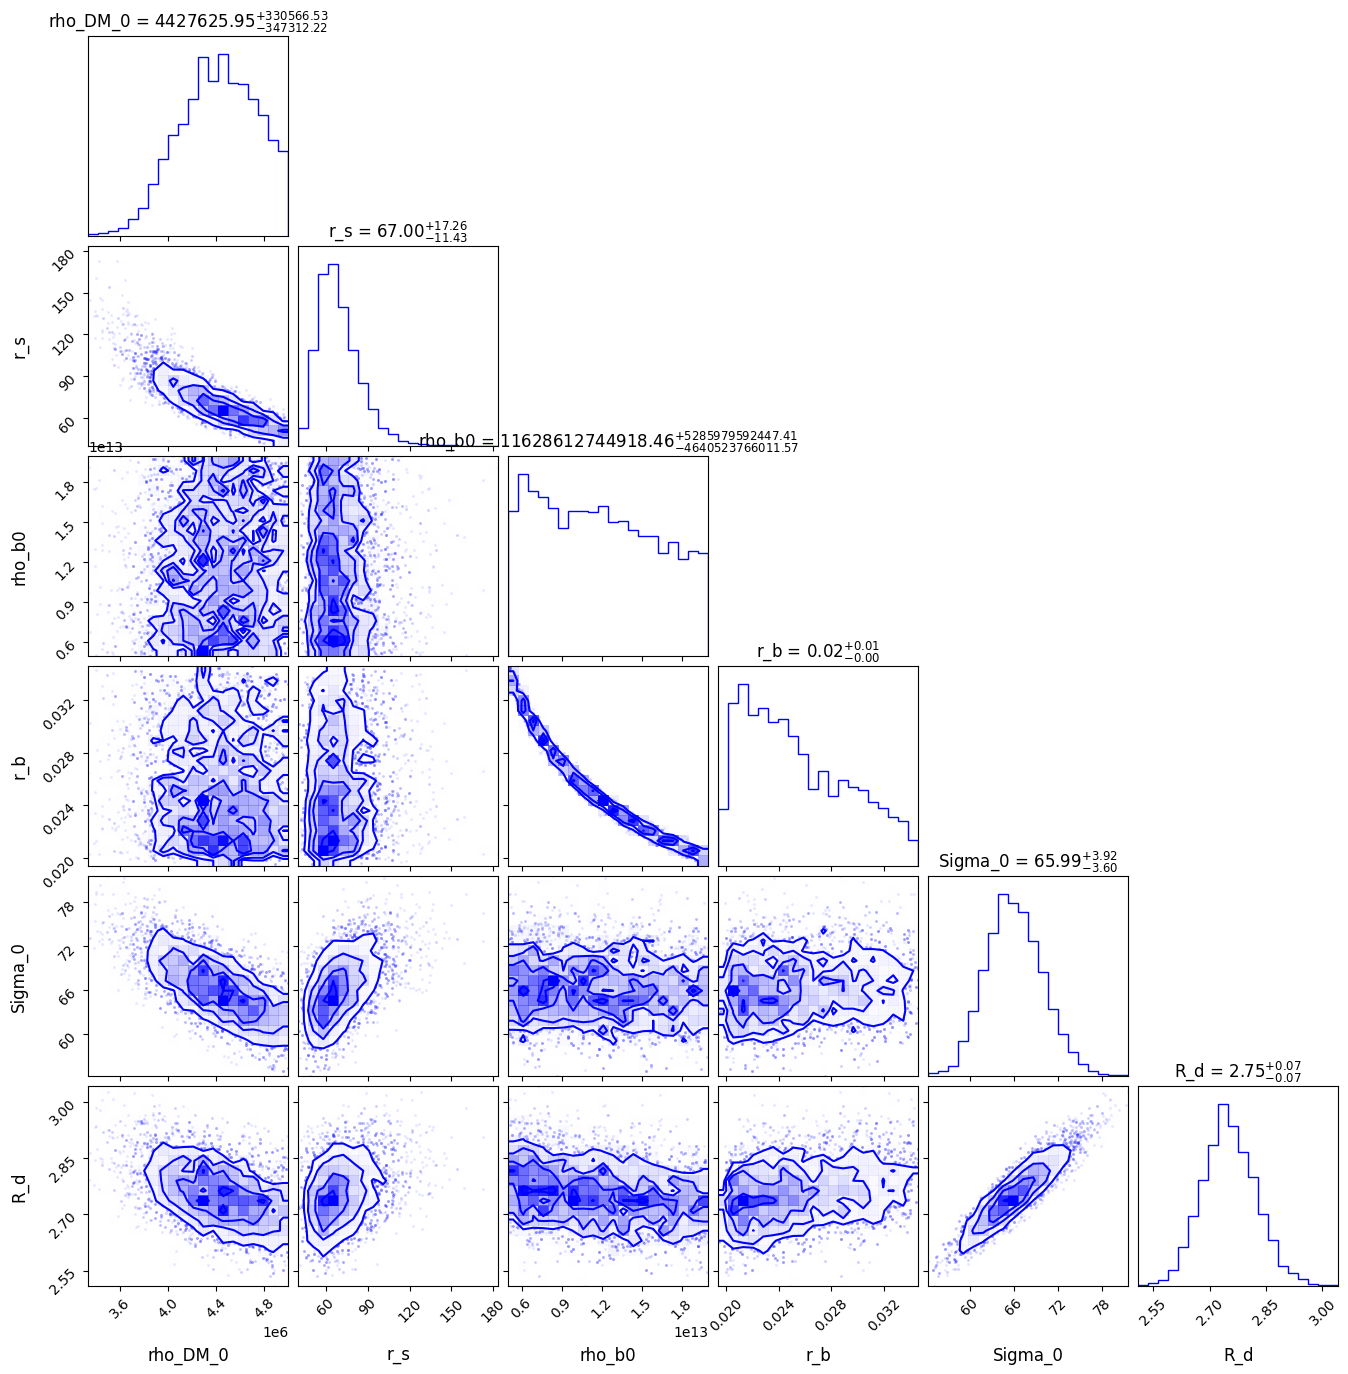

In [9]:


# Updated priors
def flat_prior(cube):
    params = cube.copy()
    for i, fid in enumerate(ranges):
        params[i] = cube[i] * (fid[1] - fid[0]) + fid[0]
    return params

# Run sampling with flat prior
flat_sampler = ReactiveNestedSampler(
    param_names, llike, flat_prior,
    log_dir=ultraroot + "/flat",
    resume='overwrite'
)
flat_results = flat_sampler.run(max_ncalls=1e6)

# Combine the results for visualization
flat_samples = flat_results['samples']

# Create a corner plot
fig = corner.corner(
    flat_samples, labels=param_names, color='blue', alpha=0.5, show_titles=True,
    label_kwargs={"fontsize": 12}
)

problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


AttributeError: 'tuple' object has no attribute 'tb_frame'